# Vorticity budget

In [2]:
import os

import xarray as xr
import numpy as np 
# from scipy.ndimage import uniform_filter, gaussian_filter

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import cmocean as cmo
import string

import warnings
warnings.filterwarnings("ignore")


In [3]:
fs_small = 18
fs_large = 24
plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fs_small)
plt.rc('ytick',labelsize=fs_small)
plt.rc('axes', labelsize=fs_large)
plt.rcParams['text.latex.preamble'] = [
    r'\usepackage{amsmath}',
    r'\usepackage{amsfonts}',
    r'\usepackage{amssymb}']
plt.rc('text', usetex=False)


In [4]:
figsdir = os.path.join(os.sep, 'g', 'data', 'v45', 'jm6603', 'checkouts', 'phd-figs', 'manuscripts', '02_manuscript')
output = os.path.join(os.sep, 'g', 'data', 'v45', 'jm6603', 'checkouts', 'phd', 'src', 'cosima', '02_manuscript', 'output')

## Load and select data

### Time and region of interest

In [5]:
# location limits of dataset
lon_lim = slice(-226, -211.5)
lat_lim = slice(-53, -47.8)

meander_period = slice('1997-02-15', '1997-05-31')
flex_period = slice('1997-04-10', '1997-04-25')
monthly_period = slice('1997-04-01', '1997-04-30')
mid_month = '1997-04-16'

period = {'meander_period': meander_period, 
          'flex_period': flex_period,
          'monthly_period': monthly_period, 
          'mid_month': mid_month}
time_period = 'flex_period'


### Load datasets

In [6]:
coordinates = xr.open_dataset(os.path.join(output, 'coordinates.nc'))
coordinates_plot = coordinates.sel(xt_ocean=lon_lim, yt_ocean=lat_lim, xu_ocean=lon_lim, yu_ocean=lat_lim)
coordinates_plot = coordinates_plot.assign_coords(
    {'xt_ocean':((coordinates_plot.xt_ocean + 180) % 360) - 180, 'xu_ocean':((coordinates_plot.xu_ocean + 180) % 360) - 180})

hydro = xr.open_dataset(os.path.join(output, 'hydro.nc'))
hydro_plot = hydro.sel(xt_ocean=lon_lim, yt_ocean=lat_lim, xu_ocean=lon_lim, yu_ocean=lat_lim)
hydro_plot = hydro_plot.assign_coords(
    {'xt_ocean':((hydro_plot.xt_ocean + 180) % 360) - 180, 'xu_ocean':((hydro_plot.xu_ocean + 180) % 360) - 180})

vel = xr.open_dataset(os.path.join(output, 'vel.nc'))
vel_plot = vel.sel(xt_ocean=lon_lim, yt_ocean=lat_lim, xu_ocean=lon_lim, yu_ocean=lat_lim)
vel_plot = vel_plot.assign_coords(
    {'xt_ocean':((vel_plot.xt_ocean + 180) % 360) - 180, 'xu_ocean':((vel_plot.xu_ocean + 180) % 360) - 180})

geos_vel = xr.open_dataset(os.path.join(output, 'geos-vel.nc'))
geos_vel_plot = geos_vel.sel(xt_ocean=lon_lim, yt_ocean=lat_lim, xu_ocean=lon_lim, yu_ocean=lat_lim)
geos_vel_plot = geos_vel_plot.assign_coords(
    {'xt_ocean':((geos_vel_plot.xt_ocean + 180) % 360) - 180, 'xu_ocean':((geos_vel_plot.xu_ocean + 180) % 360) - 180})

qgvb = xr.open_dataset(os.path.join(output, 'qgvb.nc'))
qgvb_plot = qgvb.sel(xt_ocean=lon_lim, yt_ocean=lat_lim, xu_ocean=lon_lim, yu_ocean=lat_lim)
qgvb_plot = qgvb_plot.assign_coords(
    {'xt_ocean':((qgvb_plot.xt_ocean + 180) % 360) - 180, 'xu_ocean':((qgvb_plot.xu_ocean + 180) % 360) - 180})

qgvb_dint = xr.open_dataset(os.path.join(output, 'qgvb_dint.nc'))
qgvb_dint_plot = qgvb_dint.sel(xt_ocean=lon_lim, yt_ocean=lat_lim, xu_ocean=lon_lim, yu_ocean=lat_lim)
qgvb_dint_plot = qgvb_dint_plot.assign_coords(
    {'xt_ocean':((qgvb_dint_plot.xt_ocean + 180) % 360) - 180, 'xu_ocean':((qgvb_dint_plot.xu_ocean + 180) % 360) - 180})

bpt = xr.open_dataset(os.path.join(output, 'bpt.nc'))
bpt_plot = bpt.sel(xt_ocean=lon_lim, yt_ocean=lat_lim, xu_ocean=lon_lim, yu_ocean=lat_lim)
bpt_plot = bpt_plot.assign_coords(
    {'xt_ocean':((bpt_plot.xt_ocean + 180) % 360) - 180, 'xu_ocean':((bpt_plot.xu_ocean + 180) % 360) - 180})

vst = xr.open_dataset(os.path.join(output, 'vst.nc'))
vst_plot = vst.sel(xt_ocean=lon_lim, yt_ocean=lat_lim, xu_ocean=lon_lim, yu_ocean=lat_lim)
vst_plot = vst_plot.assign_coords(
    {'xt_ocean':((vst_plot.xt_ocean + 180) % 360) - 180, 'xu_ocean':((vst_plot.xu_ocean + 180) % 360) - 180})

## Constants

In [7]:
# g = 9.81
# rho_0 = 1036 # kg/m^3
p_ref = 0 #1500
p_mld = 200
p_int = 2500
V_threshold = 0.07 #m/s

In [8]:
core_contour = -0.4
sl_contours = np.linspace(-0.4, 0.4, 5) + core_contour #[core_contour-0.2, core_contour, core_contour+0.2]
p_contours = [-0.18, -0.12, -0.06, 0.06, 0.12, 0.18]

## Pressure anomaly against long(er) term mean

In [10]:
p_baseline = hydro_plot.pressure.sel(time=period['meander_period']).mean('time')
p_anomalous = (hydro_plot.pressure.sel(time=period[time_period]) - p_baseline).compute()

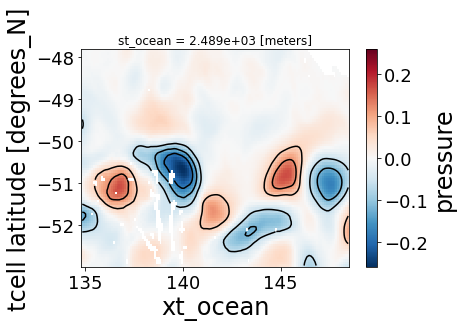

In [11]:
p_anomalous.mean('time').sel(st_ocean=2500, method='nearest').plot()
p_anomalous.mean('time').sel(st_ocean=2500, method='nearest').plot.contour(levels=[-0.18, -0.12, -0.06, 0.06, 0.12, 0.18], colors='k', linestyles='solid')

In [12]:
plt.rcParams.update(plt.rcParamsDefault)

## Vorticity budget
- QG-theory: https://www.whoi.edu/fileserver.do?id=9387&pt=2&p=12288
- Closing budget in MOM6: https://mom6-analysiscookbook.readthedocs.io/en/latest/notebooks/Closing_vorticity_budget.html

In [13]:
# plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"text.usetex": True, "font.family": 'serif', "font.serif": 'cm', 'font.size': fs_small})

Text(-0.02, 0.5, 'Latitude ($^oS$)')

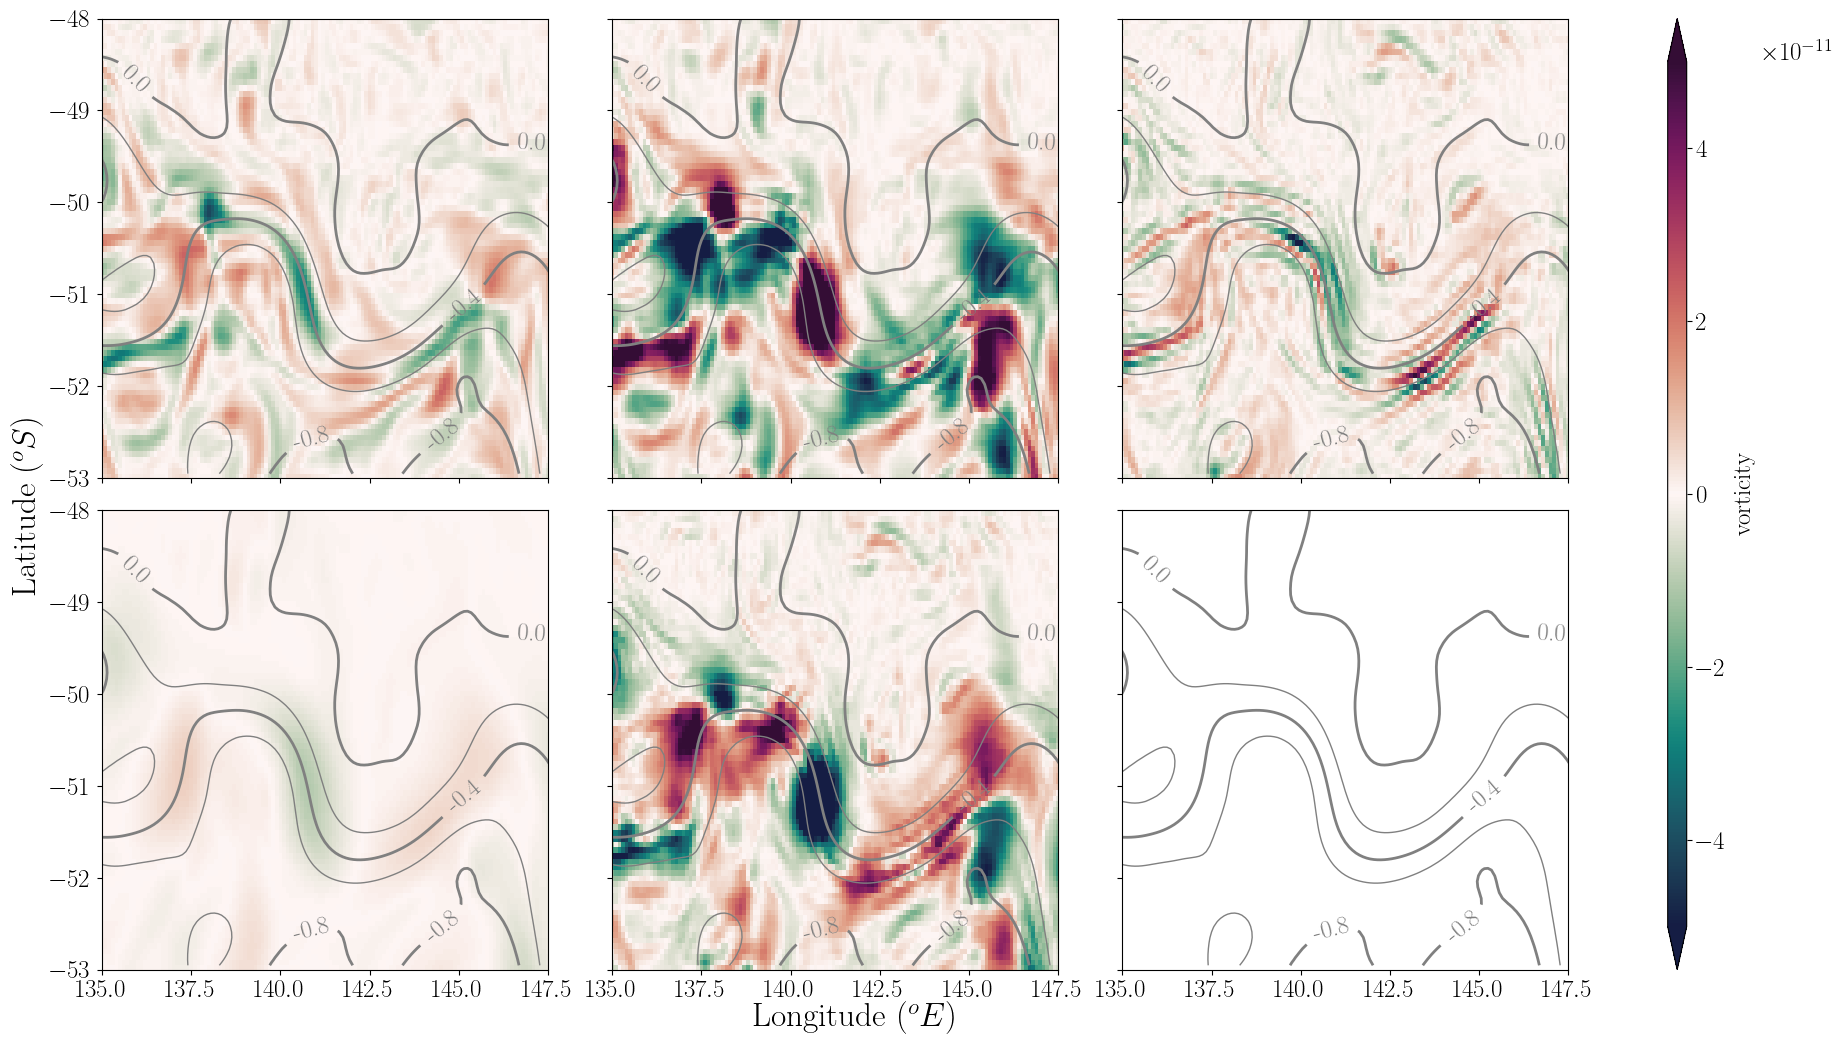

In [14]:
cmap = cmo.cm.curl
vmin, vmax = -5e-11, 5e-11
nrows, ncols = 2, 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 10), constrained_layout=True, sharex=True, sharey=True)

for iax in range(ax.size):
    r, c = iax // ncols, iax % ncols

    # if (r, c) != (0, 1):
    cont = hydro_plot.sea_level.sel(time=period[time_period]).mean('time').plot.contour(
        ax=ax[r, c], levels=sl_contours, linestyles='solid', linewidths=1, colors='gray')
    for ib, b in enumerate(sl_contours):
        if b in sl_contours[::2]:
            zc = cont.collections[ib]
            plt.setp(zc, linewidth=2)
    ax[r, c].clabel(cont, sl_contours[::2], inline=1, fontsize=fs_small, fmt='%.1f')
    
# vorticity tendency
pcol = qgvb_plot.dzetadt.sel(st_ocean=p_mld,method='nearest').sel(time=period[time_period]).mean('time').plot(
    ax=ax[0, 0], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, add_labels=False)

# advection of relative vorticity
qgvb_plot.ugradzeta.sel(st_ocean=p_mld, method='nearest').sel(time=period[time_period]).mean('time').plot(
    ax=ax[0, 1], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, add_labels=False)

# advection of planetary vorticity
qgvb_plot.betav.sel(st_ocean=p_mld, method='nearest').sel(time=period[time_period]).mean('time').plot(
    ax=ax[1, 0], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, add_labels=False)

# vortex stretching
(-qgvb_plot.fdwdz).sel(st_ocean=p_mld,method='nearest').sel(time=period[time_period]).mean('time').plot(
    ax=ax[1, 1], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, add_labels=False)

# wind stress
# stress_curl(wind_stress, grid, stress_names=('tau_x', 'tau_y')).plot(ax=ax[0, 2], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, add_labels=False)

# residual
(qgvb_plot.dzetadt + qgvb_plot.ugradzeta + qgvb_plot.betav - qgvb_plot.fdwdz).sel(
    st_ocean=p_mld,method='nearest').sel(time=period[time_period]).mean('time').plot(
    ax=ax[0, 2], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, add_labels=False)

for iax in range(ax.size):
    r, c = iax // ncols, iax % ncols
    ax[r, c].set_ylim([-53, -48])
    ax[r, c].set_xlim([135, 147.5])
    
    ax[r, c].set_xlabel('')
    ax[r, c].set_ylabel('')

cbar = fig.colorbar(pcol, ax=ax, aspect=50, extend='both')
cbar.ax.set_ylabel('vorticity')
cbar.ax.yaxis.set_offset_position('left')

# Manually set a custom offset value
custom_offset = -1  # Adjust this value as needed

# Adjust the offset text position
offset_text = cbar.ax.yaxis.get_offset_text()
x, y = offset_text.get_position()
offset_text.set_position((x + 5, y + 4))


fig.text(0.45, -0.02, r'Longitude ($^oE$)', ha='center', fontsize=fs_large)
fig.text(-0.02, 0.5, r'Latitude ($^oS$)', va='center', rotation='vertical', fontsize=fs_large)

## Vertically integrated vorticity balance

In [15]:
residual = ( qgvb_dint.dzetadt_dint + 
    qgvb_dint.ugradzeta_dint + #(!)
    qgvb_dint.betav_dint -
    qgvb_dint.fdwdz_dint# -
    # qgvb_forcing.vertical_div_wind_stress_curl.isel(time=0) +
    # qgvb_forcing.vertical_div_bottom_stress_curl.isel(time=0)
).sel(time=period[time_period]).mean('time')

Residual barotropic or depth-integrated vortivity balance check

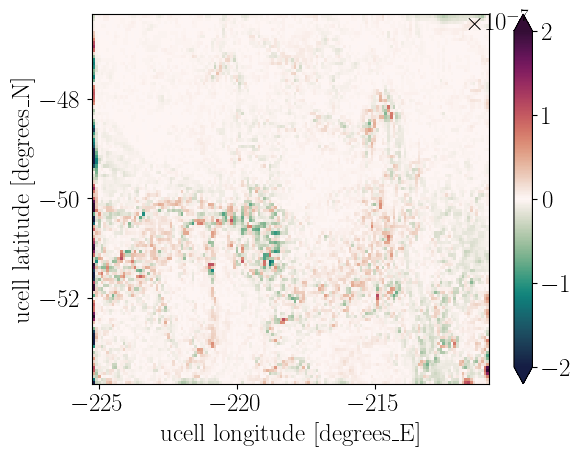

In [16]:
residual.plot(cmap=cmap, vmin=-2e-7, vmax=2e-7)

In [33]:
Vresmin = geos_vel_plot.isel(st_ocean=slice(30, -1)).sel(time=period[time_period]).mean('st_ocean').mean('time').compute()
Vgmin = geos_vel_plot.sel(st_ocean=2000, method='nearest').sel(time=period[time_period]).mean('time').compute()

In [85]:
geos_vel_plot = xr.merge([coordinates_plot.kmu, coordinates_plot.kmt, geos_vel_plot])
kmu = geos_vel_plot['kmu'].astype(int) - 1
kmu.load()
kmt = geos_vel_plot['kmt'].astype(int) - 3
kmt.load()

st_ocean = geos_vel_plot.st_ocean.expand_dims(dim={"yt_ocean": geos_vel_plot.yt_ocean, "xt_ocean": geos_vel_plot.xt_ocean})

# kmt = geos_vel_plot['kmt'].astype(int) - 10
# kmt.load()

# Vgmin = geos_vel_plot.isel(st_ocean=kmt).sel(time=period[time_period]).mean('time').compute()


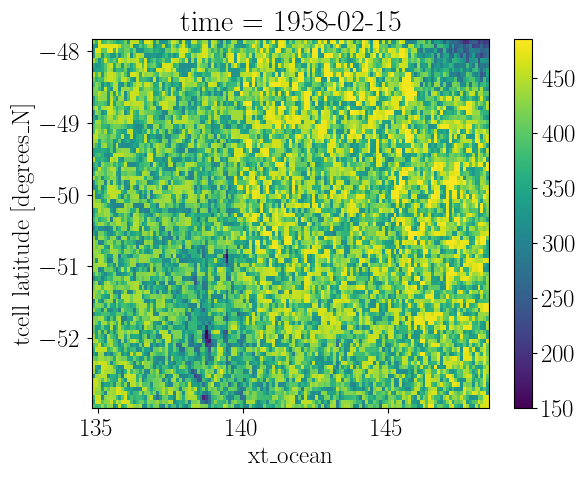

In [86]:
(coordinates_plot.ht - st_ocean.isel(st_ocean=kmt)).plot()

In [87]:
coordinates.ht

<xarray.DataArray 'ht' (yt_ocean: 115, xt_ocean: 144)>
array([[3545.6309, 3617.1309, 3617.1309, ..., 4000.1309, 3982.0596, 4020.5833],
       [3645.75  , 3645.75  , 3577.1785, ..., 4038.0356, 4038.0356, 4037.7144],
       [3636.3542, 3764.8855, 3808.0938, ..., 4122.1875, 4129.7812, 4086.7188],
       ...,
       [4235.0864, 4313.9585, 4283.0415, ..., 3698.2495, 3756.448 , 3841.1875],
       [4235.0864, 4286.521 , 4287.5415, ..., 3738.8333, 3824.0938, 3568.302 ],
       [4235.0864, 4289.2314, 4289.7593, ..., 3797.4353, 3648.8425, 2733.963 ]],
      dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -225.1 -225.0 -224.9 ... -211.0 -210.9 -210.8
  * yt_ocean  (yt_ocean) float64 -53.67 -53.61 -53.55 ... -46.5 -46.43 -46.36
    time      datetime64[ns] 1958-02-15
    geolon_t  (yt_ocean, xt_ocean) float32 -225.1 -225.1 ... -210.9 -210.9
    geolat_t  (yt_ocean, xt_ocean) float32 -53.67 -53.67 ... -46.36 -46.36
Attributes:
    long_name:      ocean depth on t-cells
    units:          m
    valid_range:    [-1.e+09  1.e+09]
    cell_methods:   time: point
    standard_name:  sea_floor_depth_below_geoid
    ncfiles:        /g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jr...
    contact:        Andrew Kiss
    email:          andrew.kiss@anu.edu.au
    created:        2020-06-09
    description:    0.1 degree ACCESS-OM2 global model configuration under in...
    notes:          Source code: https://github.com/COSIMA/access-om2 License...

In [88]:
Vgb = geos_vel_plot.Vg.isel(st_ocean=kmu).sel(time=period[time_period]).mean('time').compute()
ugb = geos_vel_plot.ug.isel(st_ocean=kmu).sel(time=period[time_period]).mean('time').compute()
vgb = geos_vel_plot.vg.isel(st_ocean=kmu).sel(time=period[time_period]).mean('time').compute()
Vgb_thres = xr.merge([Vgb, ugb, vgb]).where(Vgb >= V_threshold)

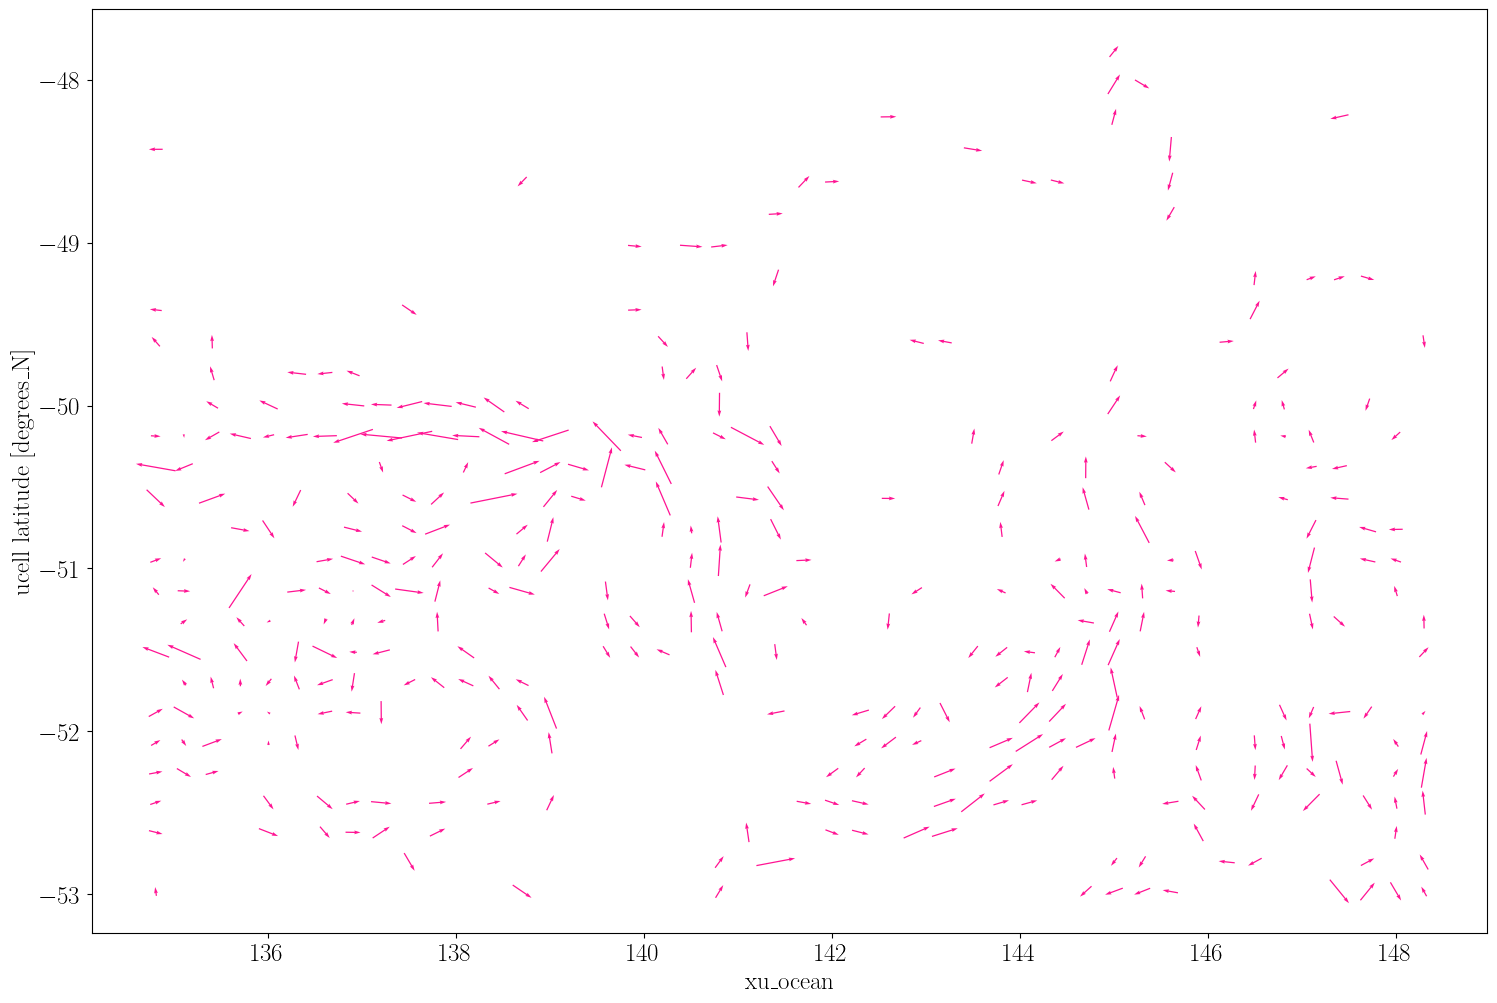

In [90]:
slc = slice(None, None, 3)

fig, ax = plt.subplots(figsize=(18,12))
quiv = Vgb_thres.sel(xu_ocean=slc, yu_ocean=slc).plot.quiver(
    ax=ax, x='xu_ocean', y='yu_ocean', u='ug', v='vg', 
    units='inches', scale=0.5, width=7e-4*fig.get_size_inches()[0], pivot='mid', color='deeppink', add_guide=False, zorder=11)
# quiv = Vgmin.where(Vgmin.Vg >= V_threshold).sel(xu_ocean=slc, yu_ocean=slc).plot.quiver(
#     ax=ax, x='xu_ocean', y='yu_ocean', u='ug', v='vg', 
#     units='inches', scale=0.5, width=7e-4*fig.get_size_inches()[0], pivot='mid', color='k', add_guide=False, zorder=11)

Text(-0.02, 0.52, 'Latitude ($^oS$)')

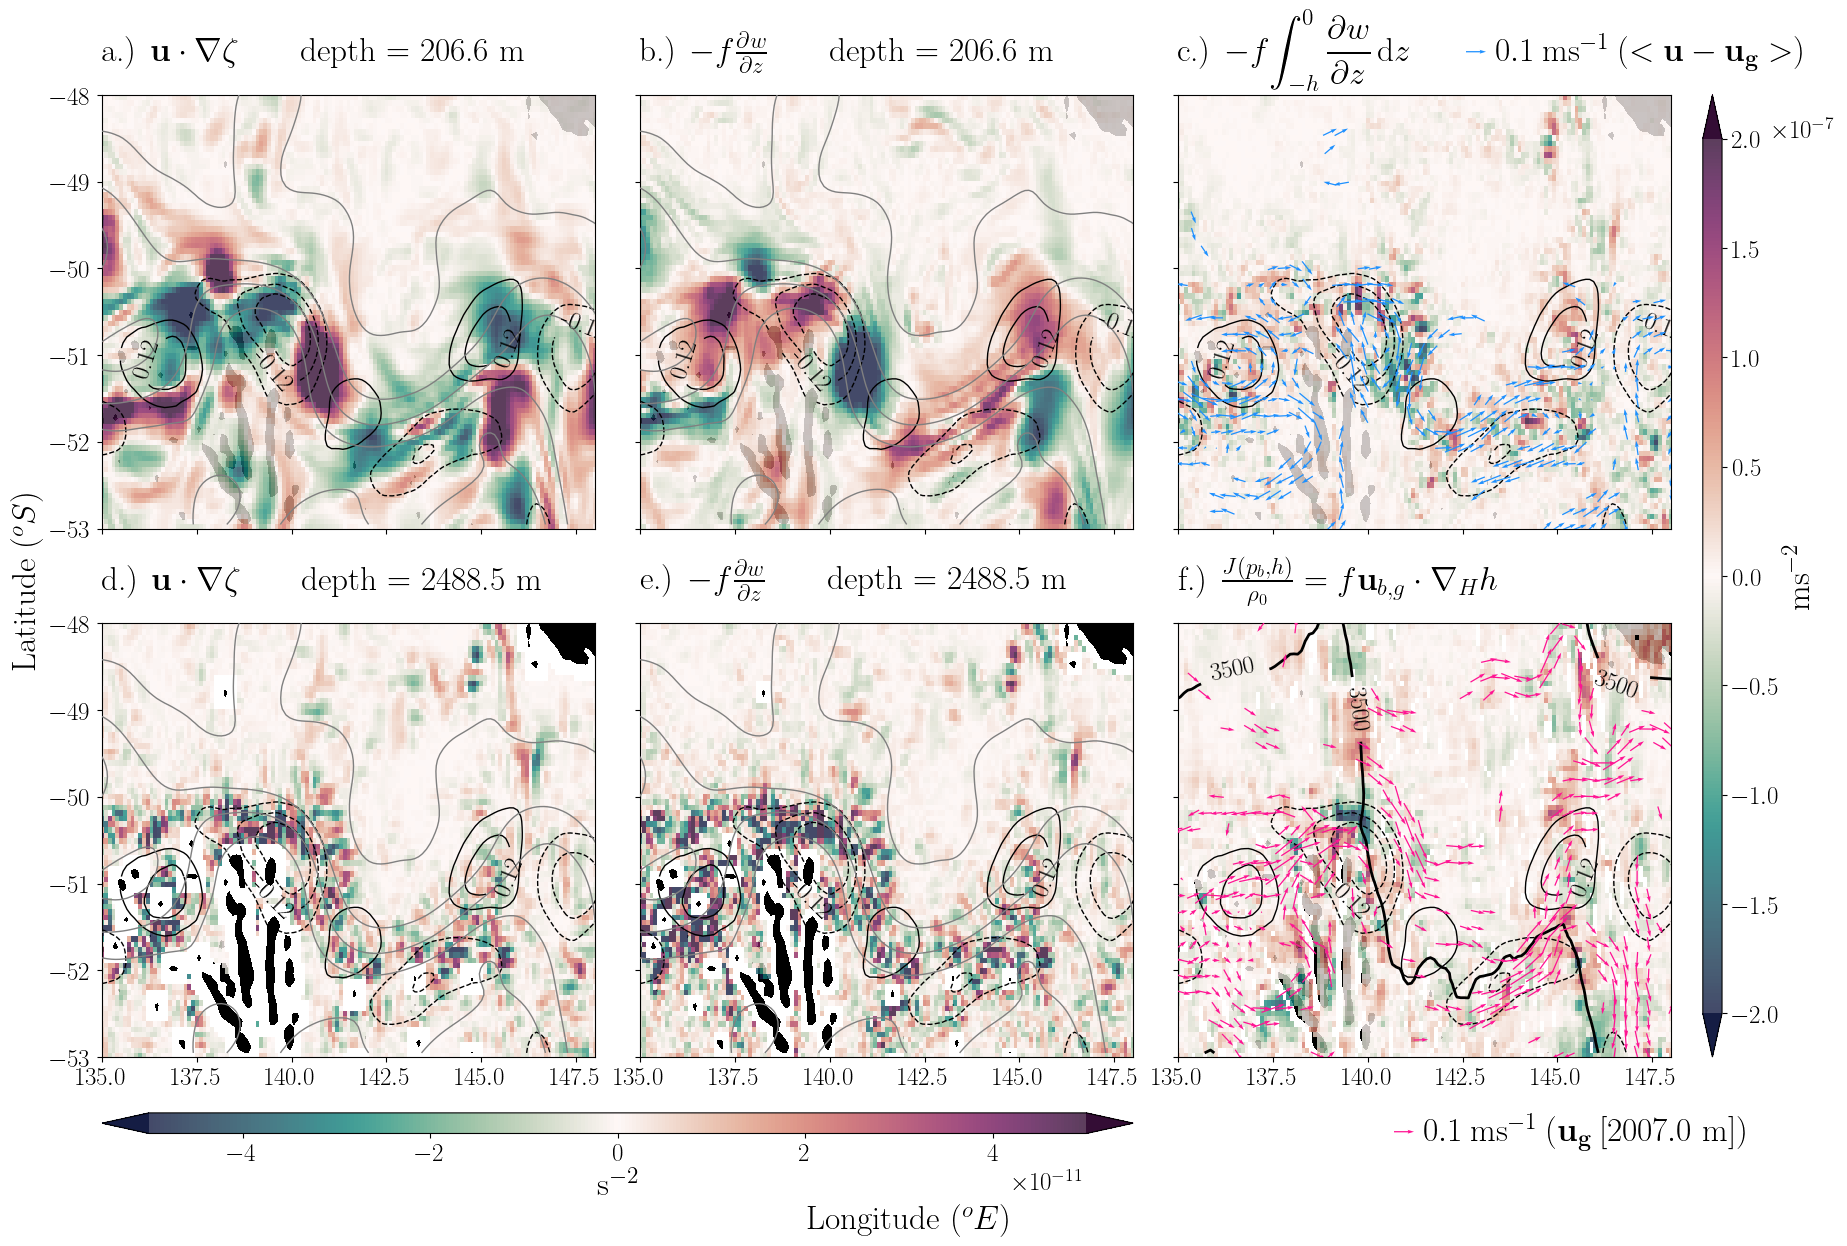

In [91]:
slc = slice(None, None, 3)
cmap = cmo.cm.curl
vmin, vmax = -5e-11, 5e-11

nrows, ncols = 2, 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 12), sharex=True, sharey=True, constrained_layout=True)

for iax in range(ax.size):
    r, c = iax // ncols, iax % ncols

    # plot topography
    if (r, c) == (1, 2):
        hcont = bpt_plot.ht_smooth.plot.contour(ax=ax[r, c], levels=[3500], colors='k', linewidths=2, zorder=3)
        ax[r, c].clabel(hcont, [3500], inline=1, fontsize=fs_small, fmt='%i')
    hydro_plot.ht.plot.contourf(ax=ax[r, c], levels=[0, 2500, 5000], colors=['k', (1, 1, 1, 0)], add_colorbar=False)
    # hydro_plot.ht.plot.contourf(ax=ax[r, c], levels=[2000, 2500], colors='k', linewidths=.25, alpha=0.2, add_colorbar=False)
    
    # plot deep pressure anomalies
    linewidths = 1#0.5 if c == 2 else 1
    pcont = p_anomalous.sel(st_ocean=p_int, method='nearest').sel(time=period[time_period]).mean('time').plot.contour(
        ax=ax[r, c], levels=p_contours, linewidths=linewidths, colors='k', zorder=9, add_labels=False)#cmap=plt.cm.RdGy)
    ax[r, c].clabel(pcont, p_contours[1::3], inline=1, fontsize=fs_small, fmt='%.2f')

    # plot geostrophic and residual velocity vectors
    if (r, c) == (0, 2):
        quiv = Vresmin.where(Vresmin.Vres >= V_threshold).sel(xu_ocean=slc, yu_ocean=slc).plot.quiver(
            ax=ax[r, c], x='xu_ocean', y='yu_ocean', u='ures', v='vres', 
            units='inches', scale=0.5, width=7e-4*fig.get_size_inches()[0], pivot='mid', color='dodgerblue', add_guide=False, zorder=11)
        qk = plt.quiverkey(quiv, 0.8, 0.96, 0.1, r'$0.1\:\mathrm{ms}^{-1}\:{(<\bf u - u_{g}>)}$', labelpos='E', coordinates='figure', 
                   fontproperties={'size': fs_large}, transform=ax[0, 0].transAxes)
    if (r, c) == (1, 2):
        quiv = Vgmin.where(Vgmin.Vg >= V_threshold).sel(xu_ocean=slc, yu_ocean=slc).plot.quiver(
            ax=ax[r, c], x='xu_ocean', y='yu_ocean', u='ug', v='vg', 
            units='inches', scale=0.5, width=7e-4*fig.get_size_inches()[0], pivot='mid', color='deeppink', add_guide=False, zorder=11)
        qk = plt.quiverkey(quiv, 0.76, 0.06, 0.1, r'$0.1\:\mathrm{ms}^{-1}\:({\bf u_{g}} \: [%s~\mathrm{m}]) $' %np.round(Vgmin.st_ocean.values,1), 
                           labelpos='E', coordinates='figure', fontproperties={'size': fs_large}, transform=ax[0, 0].transAxes)
    
    # plot sea level
    if c != 2:
        cont = hydro_plot.sea_level.sel(time=period[time_period]).mean('time').plot.contour(
            ax=ax[r, c], levels=sl_contours, linestyles='solid', linewidths=1, colors='gray', zorder=10, add_labels=False)
    # for ib, b in enumerate(sl_contours):
    #     if b in sl_contours[::2]:
    #         zc = cont.collections[ib]
    #         plt.setp(zc, linewidth=2)
    # ax[r, c].clabel(cont, sl_contours[::2], inline=1, fontsize=fs_small, fmt='%.1f')

# advection of relative vorticity near surface (200m)
data0 = qgvb_plot.ugradzeta.sel(st_ocean=p_mld, method='nearest').sel(time=period[time_period]).mean('time')
pcol = data0.plot(ax=ax[0, 0], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, add_labels=False, alpha=0.8)

# vortex stretching near surface (200m)
(-qgvb_plot.fdwdz).sel(st_ocean=p_mld, method='nearest').sel(time=period[time_period]).mean('time').plot(
    ax=ax[0, 1], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, add_labels=False, alpha=0.8)

# advection of relative vorticity near bottom (2500m)
data1 = qgvb_plot.ugradzeta.sel(st_ocean=p_int, method='nearest').sel(time=period[time_period]).mean('time')
data1.plot(ax=ax[1, 0], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, add_labels=False, alpha=0.8)

# vortex stretching near bottom (2500m)
(-qgvb_plot.fdwdz).sel(st_ocean=p_int,method='nearest').sel(time=period[time_period]).mean('time').plot(
    ax=ax[1, 1], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, add_labels=False, alpha=0.8)

# depth integrated vortex stretching
pcol1 = (-qgvb_dint_plot.fdwdz_dint).sel(time=period[time_period]).mean('time').plot(
    ax=ax[0, 2], cmap=cmap, vmin=-2e-7, vmax=2e-7, add_colorbar=False, add_labels=False, alpha=0.8)

cbar1 = fig.colorbar(pcol1, ax=ax[0:2, 2], aspect=50, extend='both')
cbar1.ax.set_ylabel('$\mathrm{ms}^{-2}$', fontsize=fs_large)
cbar1.formatter.set_powerlimits((0, 0))
offset_text = cbar1.ax.yaxis.get_offset_text()
x, y = offset_text.get_position()
offset_text.set_position((x + 6, y))
cbar1.update_ticks()

# planetary vorticity advection (depth integrated)
# bottom pressure torque
# pcol2 = qgvb_dint.betav_dint.mean('time').plot(ax=ax[1, 2], cmap=cmap, vmin=-2e-8, vmax=2e-8, add_colorbar=False)
pcol2 = bpt_plot.bpt_g_sm.sel(time=period[time_period]).mean('time').plot(
    ax=ax[1, 2], cmap=cmap, vmin=-2e-7, vmax=2e-7, add_colorbar=False, alpha=0.8)

# cbar2 = fig.colorbar(pcol2, ax=ax[1,2], extend='both')
# cbar2.ax.set_ylabel('$\mathrm{ms}^{-2}$', fontsize=fs_large)
# cbar2.formatter.set_powerlimits((0, 0))
# offset_text = cbar2.ax.yaxis.get_offset_text()
# x, y = offset_text.get_position()
# offset_text.set_position((x + 4.5, y + 1))
# cbar2.update_ticks()

for iax in range(ax.size):
    r, c = iax // ncols, iax % ncols
    ax[r, c].set_ylim([-53, -48])
    ax[r, c].set_xlim([135, 148])
    
    ax[r, c].set_xlabel('')
    ax[r, c].set_ylabel('')
    
    # labels = {${\\bf u} \\cdot \\nabla\\zeta$: {'depth': p_mld}}
    if (c == 0):
        # ax[iax].text(0, 1.05, string.ascii_lowercase[iax] + '.) depth = %s m' %np.round(qgvb.ugradzeta.sel(st_ocean=p_mld, method='nearest').st_ocean.values,1),
        #      transform=ax[iax].transAxes, size=fs_large)
        depth = np.round(data0.st_ocean.values,1) if r == 0 else np.round(data1.st_ocean.values,1)
        ax[r, c].text(0, 1.08, string.ascii_lowercase[iax] + '.) ' + r'${\bf u}\cdot\nabla\zeta \quad\quad$' + 'depth = %s m' %depth,
                      transform=ax[r, c].transAxes, size=fs_large, weight='bold')
    if (c == 1):
        depth = np.round(data0.st_ocean.values,1) if r == 0 else np.round(data1.st_ocean.values,1)
        ax[r, c].text(0, 1.08, string.ascii_lowercase[iax] + '.) '+ r'$-f\frac{\partial w}{\partial z} \quad\quad$' + 'depth = %s m' %depth,
                 transform=ax[r, c].transAxes, size=fs_large, weight='bold')
    if (r == 0) & (c == 2):
        ax[r, c].text(0, 1.08, string.ascii_lowercase[iax] + '.) '+ r'$-f {\displaystyle \int_{-h}^0 \frac{\partial w}{\partial z} \, \mathrm{d}z }$',
                 transform=ax[r, c].transAxes, size=fs_large, weight='bold')
    if (r == 1) & (c == 2):
        ax[r, c].text(0, 1.08, string.ascii_lowercase[iax] + '.) '+ r'$\frac{J(p_b, h)}{\rho_0} = f{\bf u}_{b,g} \cdot \nabla_H h$',
                 transform=ax[r, c].transAxes, size=fs_large, weight='bold')
# fig.delaxes(ax[2, 1])

cbar = fig.colorbar(pcol, ax=ax[1,:-1], aspect=50, extend='both', orientation='horizontal')
cbar.ax.set_xlabel('$\mathrm{s}^{-2}$', fontsize=fs_large)

fig.text(0.48, -0.02, r'Longitude ($^oE$)', ha='center', fontsize=fs_large)
fig.text(-0.02, 0.52, r'Latitude ($^oS$)', va='center', rotation='vertical', fontsize=fs_large)

In [92]:
savefig=True
if savefig:
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        transparent = True if extension == '.png' else False
        fig.savefig(os.path.join(figsdir, '08_vort-budget' + extension), 
                    transparent=transparent, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


## Bottom pressure torque

<a list of 3 text.Text objects>

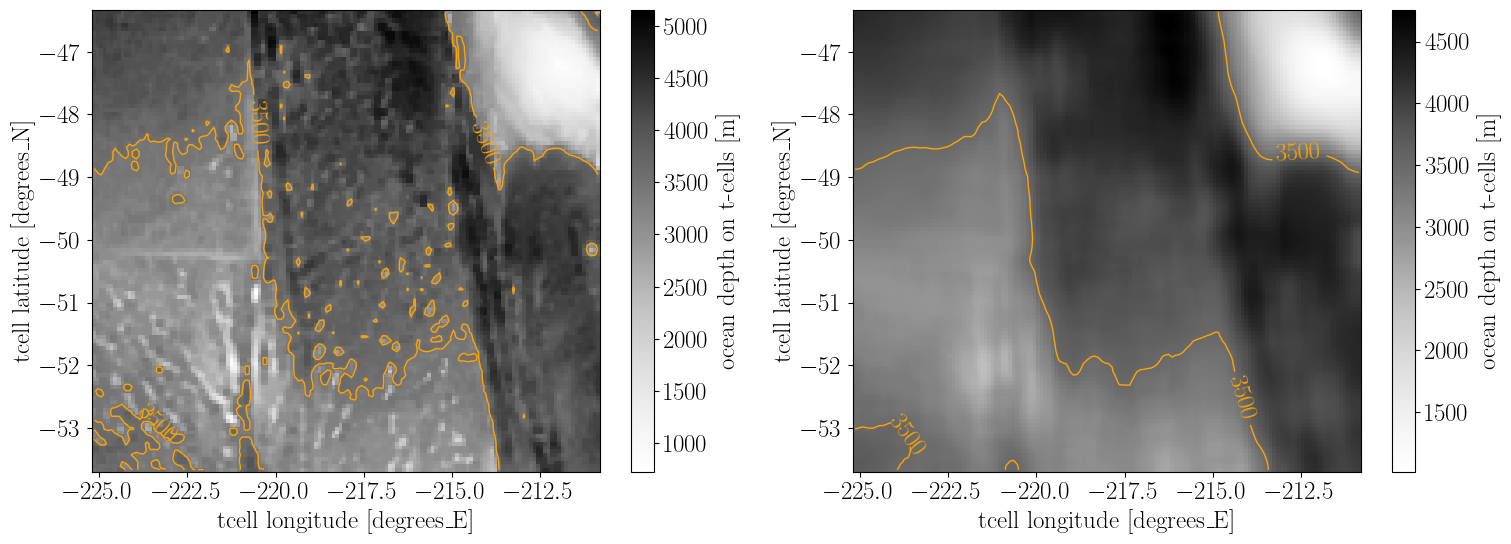

In [36]:
fig, ax = plt.subplots(ncols=2, figsize=(18,6))
bpt.ht.plot(ax=ax[0], cmap='Greys')
hcont = bpt.ht.plot.contour(ax=ax[0], levels=[3500], colors='orange', linewidths=1, zorder=3)
ax[0].clabel(hcont, [3500], inline=1, fontsize=fs_small, fmt='%i')

bpt.ht_smooth.plot(ax=ax[1], cmap='Greys')
hcont = bpt.ht_smooth.plot.contour(ax=ax[1], levels=[3500], colors='orange', linewidths=1, zorder=3)
ax[1].clabel(hcont, [3500], inline=1, fontsize=fs_small, fmt='%i')


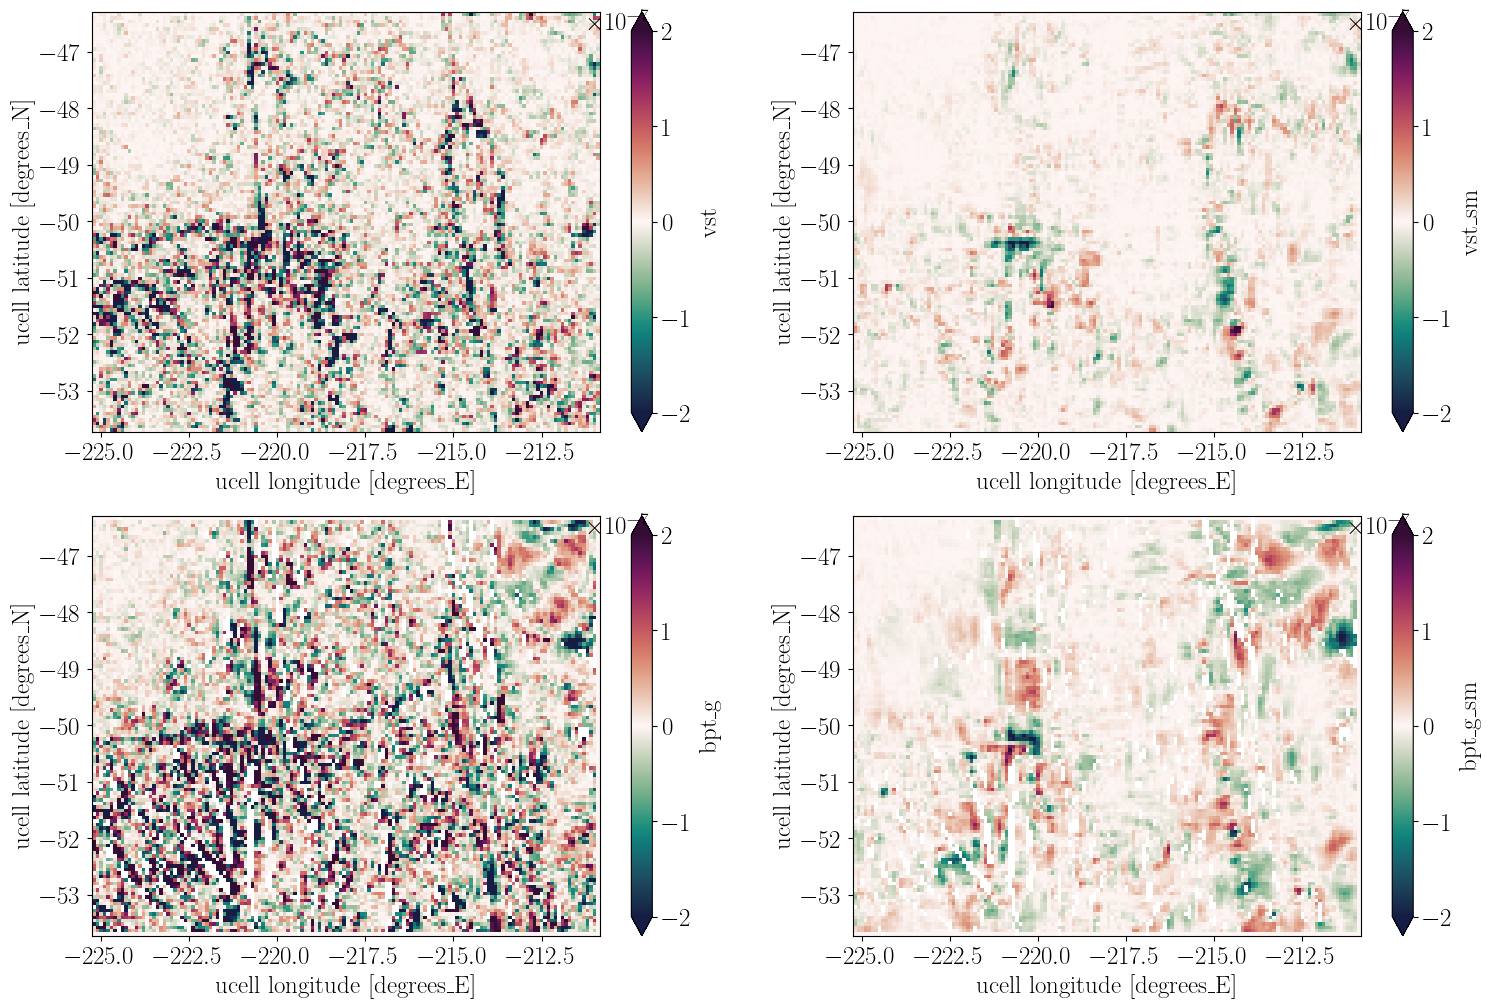

In [18]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(18,12))
vst.vst.sel(time=period[time_period]).mean('time').plot(ax=ax[0, 0], cmap=cmo.cm.curl, vmin=-2e-7, vmax=2e-7)
vst.vst_sm.sel(time=period[time_period]).mean('time').plot(ax=ax[0, 1], cmap=cmo.cm.curl, vmin=-2e-7, vmax=2e-7)

bpt.bpt_g.sel(time=period[time_period]).mean('time').plot(ax=ax[1, 0], cmap=cmo.cm.curl, vmin=-2e-7, vmax=2e-7)
bpt.bpt_g_sm.sel(time=period[time_period]).mean('time').plot(ax=ax[1, 1], cmap=cmo.cm.curl, vmin=-2e-7, vmax=2e-7)


In [19]:
Vresmin = geos_vel_plot.isel(st_ocean=slice(30, -1)).sel(time=period[time_period]).mean('st_ocean').mean('time').compute()
Vgmin = geos_vel_plot.sel(st_ocean=2500, method='nearest').sel(time=period[time_period]).mean('time').compute()

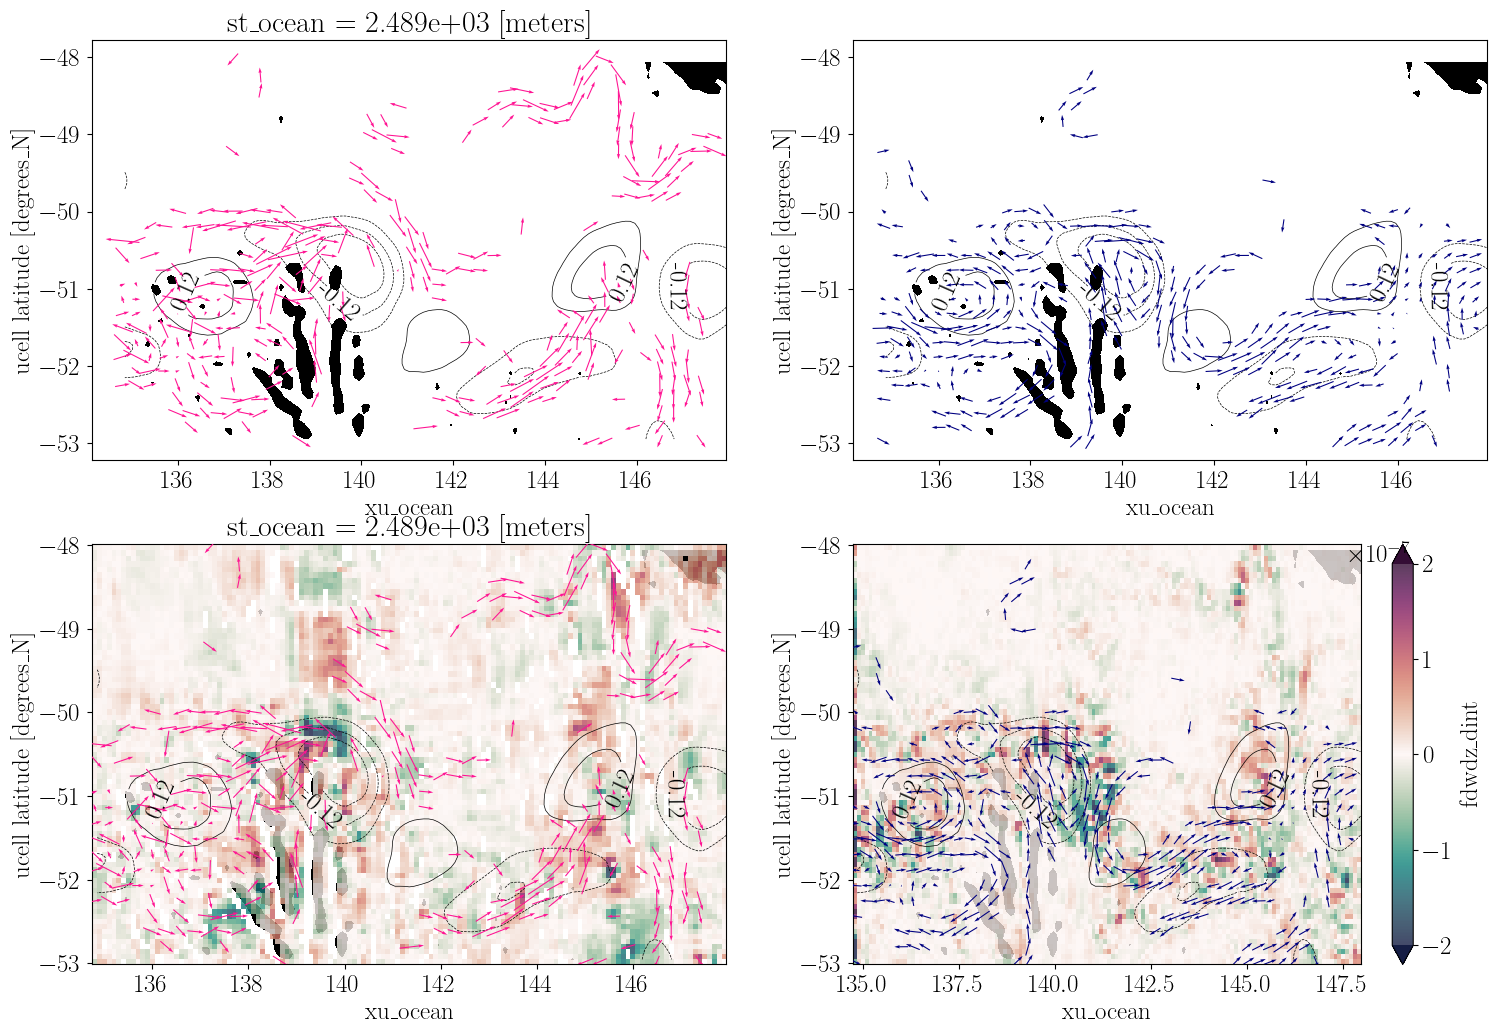

In [26]:
ncols =2
fig, ax = plt.subplots(ncols=ncols, nrows=2, figsize=(18,12))

for iax in range(ax.size):
    r, c = iax // ncols, iax % ncols
    hydro_plot.ht.plot.contourf(ax=ax[r, c], levels=[0, 2500, 5000], colors=['k', (1, 1, 1, 0)], add_colorbar=False)
    # hydro.ht.plot.contourf(ax=ax[r, c], levels=[2000, 2500], colors='k', alpha=0.2, add_colorbar=False, zorder=9)

    # plot geostrophic and residual velocity vectors
    if c == 1:
        # geos_vel.sel(st_ocean=1500, method='nearest').sel(time=flex_period).mean('time').sel(xu_ocean=slc, yu_ocean=slc).plot.quiver(
        #     ax=ax[r, c], x='xu_ocean', y='yu_ocean', u='ures', v='vres',
        #     units='inches', scale=0.5, width=6e-4*fig.get_size_inches()[0], pivot='mid', add_guide=False, color='k', zorder=11)
        Vresmin.where(Vresmin.Vres >= 0.065).sel(xu_ocean=slc, yu_ocean=slc).plot.quiver(
            ax=ax[r, c], x='xu_ocean', y='yu_ocean', u='ures', v='vres', 
            units='inches', scale=0.5, width=6e-4*fig.get_size_inches()[0], pivot='mid', color='navy', add_guide=False, zorder=11)
    if c == 0:
        Vgmin.where(Vgmin.Vg >= 0.075).sel(xu_ocean=slc, yu_ocean=slc).plot.quiver(
            ax=ax[r, c], x='xu_ocean', y='yu_ocean', u='ug', v='vg', 
            units='inches', scale=0.5, width=6e-4*fig.get_size_inches()[0], pivot='mid', color='deeppink', add_guide=False, zorder=11)
        
    # plot deep pressure anomalies
    pcont = p_anomalous.sel(st_ocean=p_int, method='nearest').sel(time=period[time_period]).mean('time').plot.contour(
        ax=ax[r, c], levels=p_contours, colors='k', linewidths=0.5, zorder=9, add_labels=False)
    ax[r, c].clabel(pcont, p_contours[1::3], inline=1, fontsize=fs_small, fmt='%.2f')

vst_plot.vst_sm.sel(time=period[time_period]).mean('time').plot(ax=ax[0, 0], cmap=cmo.cm.curl, vmin=-2e-7, vmax=2e-7, add_colorbar=False, add_labels=False, alpha=0.8)


vst_plot.fwb.sel(time=period[time_period]).mean('time').plot(ax=ax[0, 1], cmap=cmo.cm.curl, vmin=-2e-7, vmax=2e-7, alpha=0.8)


bpt_plot.bpt_g_sm.sel(time=period[time_period]).mean('time').plot(ax=ax[1, 0], cmap=cmo.cm.curl, vmin=-2e-7, vmax=2e-7, add_colorbar=False, add_labels=False, alpha=0.8)


(-qgvb_dint_plot.fdwdz_dint).sel(time=period[time_period]).mean('time').plot(ax=ax[1, 1], cmap=cmo.cm.curl, vmin=-2e-7, vmax=2e-7, alpha=0.8)



In [ ]:
fig, ax=plt.subplots(ncols=3, figsize=(18,6), sharey=True, constrained_layout=True)

pcol = (-fw_b).mean('time').plot(ax=ax[0], cmap=cmap, vmin=-2e-7, vmax=2e-7, add_colorbar=False)
fdwdz_dint.mean('time').plot(ax=ax[1], cmap=cmap, vmin=-2e-7, vmax=2e-7, add_colorbar=False)
VST.mean('time').plot(ax=ax[2], cmap=cmap, vmin=-2e-7, vmax=2e-7, add_colorbar=False)

for iax in range(len(ax)):
    
#     # if (r, c) != (0, 1):
    cont = sl_lim.sel(time=period[time_period]).mean('time').plot.contour(
        ax=ax[iax], levels=sl_contours, linestyles='solid', linewidths=1, colors='gray')
    p_anomalous.isel(st_ocean=last_cell).sel(time=period[time_period]).mean('time').plot.contour(
        ax=ax[iax], levels=[-0.18, -0.12, -0.06, 0.06, 0.12, 0.18], colors='k', linestyles='solid')

# cbar = fig.colorbar(pcol, ax=ax, aspect=50, extend='both')
# cbar.ax.set_ylabel('vorticity')

## Vertical component of the curl of the horizontal frictional forces

$$ \nabla_H \times \tau_w = \frac{\partial \tau_{w,y}}{\partial x} - \frac{\partial \tau_{w,x}}{\partial y}$$

#TODO:
- calculate bottom pressure torque as fw_b (best estimate with daily output), explain anologies with other forms of BPT calculations in manuscript
- compare monthly mean terms to dialy terms averaged over month
- check beta v for negative in residual